In [3]:
import sys
import numpy as np
import pandas as pd
import scipy.stats
import stdatamodels.jwst.datamodels as dm
import matplotlib.pyplot as plt
import os


os.environ['CRDS_PATH'] = "/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/CRDS/"
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

from glob import glob
from astropy.visualization import ZScaleInterval
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.widgets import Slider
from importlib import reload
from scipy.optimize import curve_fit as cfit

from jwst.pipeline import Spec2Pipeline, Spec3Pipeline, Detector1Pipeline
from BNBG.utils.utils import getSourcePosition

directory = "/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/TestSingleSlit/"

# Keep only one source for faster tests

In [ ]:
msa = fits.open(directory + "jw01345063001_01_msa.fits")

keep = [22800, 1622, 3212, 749, 9619]

mask = [_ in keep for _ in msa[2].data["source_id"]]
msa[2].data = msa[2].data[mask]
mask = [_ in keep for _ in msa[3].data["source_id"]]
msa[3].data = msa[3].data[mask]

msa.writeto(directory + "jw01345063001_01_msa.fits", overwrite=True)


# Det 1 Stage

In [ ]:
uncal_list = glob(directory + "*_uncal.fits")

for uncal in uncal_list:
	steps = {
                    'jump': {'expand_large_events': True,
                             # 1st flag groups after jump above DN threshold.
                             'after_jump_flag_dn1': 0,
                             # 1st flag groups after jump groups within
                             # specified time.
                             'after_jump_flag_time1': 0,
                             # 2nd flag groups after jump above DN threshold.
                             'after_jump_flag_dn2': 0,
                             # 2nd flag groups after jump groups within
                             # specified time.
                             'after_jump_flag_time2': 0,
                             # Minimum required area for the central saturation
                             # of snowballs.
                             'min_sat_area': 15.0,
                             # Minimum area to trigger large events processing.
                             'min_jump_area': 15.0,
                             # The expansion factor for the enclosing circles
                             # or ellipses.
                             'expand_factor': 20.0},
                }
	det1 = Detector1Pipeline(steps=steps)
	for step in det1.steps:
		getattr(det1, step).save_results = True
	det1.output_dir = directory + "Stage1/"
	det1.save_results = True
	det1.run(uncal)

In [ ]:
det1_files = glob(directory + "Stage1/*")
det1_files.sort(key=os.path.getmtime)
datalist = []

ylim = (1567, 1992)
xlim = (386, 411)

for file in det1_files:
	file = fits.open(file)

	if len(file[1].data.shape) == 2:
		data = file[1].data[xlim[0]:xlim[1], ylim[0]:ylim[1]]

	if len(file[1].data.shape) == 3:
		data = file[1].data[0, xlim[0]:xlim[1], ylim[0]:ylim[1]]

	if len(file[1].data.shape) == 4:
		data = file[1].data[0, 13, xlim[0]:xlim[1], ylim[0]:ylim[1]]

	z1,z2 = ZScaleInterval().get_limits(data)
	plt.figure(figsize=(10, 2))
	plt.subplot(211)
	plt.imshow(data, cmap="plasma", vmin=z1, vmax=z2)
	plt.title(os.path.basename(file.filename())[31:])

	if len(datalist) > 0:
		residual = data - datalist[-1]
		z1,z2 = ZScaleInterval().get_limits(residual)
		plt.subplot(212)
		plt.imshow(residual, cmap="seismic", vmin=z1, vmax=z2)

	plt.show()
	datalist.append(data)

	file.close()

In [ ]:
from jwst.jump import JumpStep

dark = [_ for _ in det1_files if "dark_current" in _][0]
dark = dm.open(dark)

In [ ]:
jump = JumpStep()
jump.expand_large_events = True
jump.after_jump_flag_dn1 = 0
jump.after_jump_flag_time1 = 0
jump.after_jump_flag_dn2 = 0
jump.after_jump_flag_time2 = 0
jump.min_sat_area = 15.0
jump.min_jump_area = 15.0
jump.expand_factor = 20.0
j = jump.run(dark)

plt.figure(figsize=(14, 2))
_ = dm.open([_ for _ in det1_files if "jump" in _][0])
data1 = _.data[0,13,xlim[0]:xlim[1], ylim[0]:ylim[1]]
z1,z2 = ZScaleInterval().get_limits(data1)
plt.imshow(data1, cmap="plasma", vmin=z1, vmax=z2, interpolation='none')
plt.show()

plt.figure(figsize=(14, 2))
data2 = j.data[0,13,xlim[0]:xlim[1], ylim[0]:ylim[1]]
z1,z2 = ZScaleInterval().get_limits(data2)
plt.imshow(data2, cmap="plasma", vmin=z1, vmax=z2, interpolation='none')
plt.show()

plt.figure(figsize=(14, 2))
data = data1 - data2
z1,z2 = ZScaleInterval().get_limits(data)
plt.imshow(data, cmap="seismic", vmin=z1, vmax=z2, interpolation='none')
plt.show()



# Treat both with and without subtraction

Stage 1

In [ ]:
uncal_list = glob(directory + "*_uncal.fits")

for uncal in uncal_list:
	det1 = Detector1Pipeline()
	det1.output_dir = directory
	det1.save_results = True
	det1.run(uncal)

Stage 2

In [ ]:
asn_list = glob(directory + "*spec2*asn*")
for asn in asn_list:
	steps = {'master_background_mos': {'skip': True},
				 'bkg_subtract': {'skip': True},
				 'extract_1d': {'skip': True},
				 "photom": {"source_type": "EXTENDED"}, # Will normalize every flux by the size of a pixel
				 "pathloss": {"source_type": "EXTENDED"}, # Spectral correction to be independent of spatial position
				 "barshadow": {"source_type": "EXTENDED"} # (Almost) gets rid of envelope around each shutter
				 }
	spec2 = Spec2Pipeline(steps=steps)
	spec2.output_dir = directory + "NoSub/"
	spec2.save_results = True
	#spec2.run(asn)

	spec2 = Spec2Pipeline()
	spec2.output_dir = directory + "Default/"
	spec2.save_results = True
	spec2.run(asn)

for folder in ["Default/"]:#["Default/", "NoSub/"]:
	asn = directory + folder + "jw01345-o063_20241001t101453_spec3_00001_asn.json"
	spec3 = Spec3Pipeline()
	spec3.output_dir = directory + folder
	spec3.save_results = True
	spec3.run(asn)

# Read output logs

In [ ]:
def removeDate(input_file):
	with open(input_file, "r") as file:
		lines = file.readlines()

	# Process the lines
	processed_lines = []
	for line in lines:
		if "stpipe." in line:
			truncated_line = line.split("stpipe.", 1)[1]  # Keep everything after "stpipe."
			truncated_line = "stpipe." + truncated_line  # Add "stpipe." back at the beginning
			processed_lines.append(truncated_line)
		else:
			processed_lines.append(line)  # Keep lines unchanged if "stpipe." not found

	# Write the processed lines to a new file
	with open(input_file, "w") as file:
		file.writelines(processed_lines)

removeDate(directory+"nosub.log")
removeDate(directory+"default.log")


In [ ]:
import difflib

with open(directory+"nosub.log", "r") as f1, open(directory+"default.log", "r") as f2:
	lines1 = f1.readlines()
	lines2 = f2.readlines()

# Use difflib to compare the lines
differ = difflib.unified_diff(lines1, lines2, lineterm="", n=0)

# Print the differences
print("Differences between the files:")
for line in differ:
	if "@@" in line:
		print("\n")
	print(line.strip())


# Compare both stage 2 cal files

In [ ]:
nosub = dm.open(directory + "NoSub/jw01345063001_03101_00001_nrs1_s2d.fits").slits[0].data
default = dm.open(directory + "Default/jw01345063001_03101_00001_nrs1_s2d.fits").slits[0].data

print(np.nanmin(nosub), np.nanmax(nosub))
print(np.nanmin(default), np.nanmax(default))

plt.figure(figsize=(12,2))
residual = nosub - default
z1, z2 = ZScaleInterval().get_limits(residual)
plt.imshow(residual, origin="lower", vmin=z1, vmax=z2)
plt.show()

plt.figure(figsize=(12,2))
z1, z2 = ZScaleInterval().get_limits(nosub)
plt.imshow(nosub, origin="lower", vmin=z1, vmax=z2)
plt.show()

# Manual background subtraction

In [ ]:
rate_list = glob(directory + "NoSub/*nrs1*cal.fits")
rate_list = [dm.open(_).slits[0].data for _ in rate_list]

%matplotlib Qt5Agg

In [ ]:
fig, ax = plt.subplots(figsize=(14,3))


# Slider
ax_slider1 = plt.axes((0.2, 0.05, 0.6, 0.03))
slider1 = Slider(ax_slider1, '1', -1, 1, valinit=0, valstep=0.01)
ax_slider2 = plt.axes((0.2, 0.02, 0.6, 0.03))
slider2 = Slider(ax_slider2, '2', -1, 1, valinit=0, valstep=0.01)


def update(val):
	c1 = slider1.val
	c2 = slider2.val

	img = rate_list[2] - c2*((1-c1)/2*rate_list[0] + (1+c1)/2*rate_list[1])
	z1, z2 = ZScaleInterval().get_limits(img)

	ax.imshow(img, origin='lower', interpolation='none', vmin=z1, vmax=z2)
	xlim = ax.get_xlim()
	ylim = ax.get_ylim()
	ax.clear()
	ax.imshow(img, origin='lower', interpolation='none', vmin=z1, vmax=z2)

#	xlim = (1567,1992)
#	ylim = (386,411)
	ax.set_ylim(*ylim)
	ax.set_xlim(*xlim)
update(0)

# Attach the update function to the slider
slider1.on_changed(update)
slider2.on_changed(update)

plt.show()

# Reduced Chi Squared

In [ ]:
from BNBG.Pipeline.BSplineLSQ import BSplineLSQ

x = np.linspace(-5,5,20)
y = x**2 + np.random.normal(size=len(x),scale=1)
w = np.ones_like(x)

bspline = BSplineLSQ(x,y,w,n=0.2,k=3)

plt.figure()
plt.grid()
plt.scatter(x,y,color='k',marker='+')
X = np.linspace(-5,5,100)
plt.plot(X,bspline(X))
plt.scatter(bspline.t, bspline(bspline.t), color='g')
plt.plot(X,X**2,color='r')
plt.show()
print(bspline.getChiSquare(), bspline.getReducedChi(), bspline.getDegreesOfFreedom())
print(bspline.getChiSquare(), bspline.getReducedChi()/(bspline.ncoeffs + bspline.k), bspline.ncoeffs + bspline.k)

plt.figure()
plt.grid()
plt.scatter(x,y-bspline(x),color='k',marker='+')
plt.show()

In [ ]:
plt.figure()
for _ in range(100):
	x = np.linspace(-5,5,200)
	y = 2*x**2 + np.random.normal(size=len(x),scale=1)
	w = np.ones_like(x)

	N = 1-np.linspace(0.8,1,20)
	chi2 = []
	for n in N:
		bspline = BSplineLSQ(x,y,w,n=n)
		chi2.append(bspline.getReducedChi())


	plt.scatter(N,chi2,color='k',marker='+',alpha=0.5)

plt.hlines(1,0,1,color='r',linestyle='--')
plt.xlim(0,0.1)
plt.xlabel('n')
plt.ylabel('chi2 reduced')
plt.grid()
plt.show()

# Fit Analysis


In [ ]:
directory = '/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/'
csvs = glob(directory + '*.csv')
csvs = [pd.read_csv(_,sep="\t") for _ in csvs]
csv = pd.concat(csvs)
csv

In [ ]:
plt.figure()
plt.grid()
plt.scatter(csv["datapoints"],csv["reducedChi2"],marker='+',color='k',alpha=0.5)
plt.yscale('log')
plt.ylabel('Reduced Chi2')
plt.xlabel('Datapoints')
plt.show()

plt.figure()
plt.hist(np.log(csv["reducedChi2"]),bins=100)
plt.grid()
plt.yscale('log')
plt.show()


In [ ]:
%matplotlib Qt5Agg
plt.close("all")
for i, key in enumerate(csv.keys()):
	if key in ["slit", "source"]:
		continue
	for j in range(i):
		if csv.keys()[j] in ["slit", "source"]:
			continue
		plt.figure()
		plt.grid()
		plt.scatter(csv[key],csv[csv.keys()[j]],marker='+',color='k',alpha=0.5)
		plt.ylabel(csv.keys()[j])
		plt.xlabel(key)
		plt.show()


# Optimal n for a spectra


In [ ]:
from BNBG.Pipeline.PipelineStages import Stage2
asn_list = glob((directory+"NoSub/*spec2*asn.json"))
N = 1-np.linspace(0,1,10)

csvs = glob(directory + 'NoSub/*.csv')
csvs = [pd.read_csv(_,sep="\t") for _ in csvs]
csv = pd.concat(csvs)
N_list = [np.nan, np.nan, np.nan]

for n in N:
	for asn in asn_list:
		Stage2(asn, directory+"NoSub/", interpolationKnots=n)
		N_list.append(n)
	csvs = glob(directory + 'NoSub/*.csv')
	csvs = [pd.read_csv(_,sep="\t") for _ in csvs]
	csvs.append(csv)
	csv = pd.concat(csvs)

	toRemove = glob(directory + 'NoSub/*BNBG.fits')
	for _ in toRemove:
		os.remove(_)

In [ ]:
%matplotlib inline
plt.figure()
plt.grid()
plt.scatter(N_list[::3], csv["reducedChi2"][::3],marker='+',color='r', label="0001")
plt.scatter(N_list[1::3], csv["reducedChi2"][1::3],marker='+',color='g', label="0003")
plt.scatter(N_list[2::3], csv["reducedChi2"][2::3],marker='+',color='b', label="0002")
plt.yscale("log")
plt.legend()
plt.show()

for asn in asn_list:
		Stage2(asn, directory+"NoSub/", interpolationKnots=1)

# Outlier Detection


In [ ]:
asn = glob(directory + 'NoSub/*spec3*asn.json')[0]

steps = {"assign_mtwcs":{"save_results":True}}
spec3 = Spec3Pipeline(steps=steps)
spec3.save_results = True
spec3.output_dir = directory+"NoSub/"
spec3.run(asn)

In [ ]:
from jwst.datamodels import SourceModelContainer
from jwst.outlier_detection import OutlierDetectionStep

cal = dm.open(directory+"NoSub/jw01345-o063_s000022800_nirspec_clear-prism_cal.fits")
cal = SourceModelContainer(cal)

step = OutlierDetectionStep()
step.scale ="0.0 0.0"
step.snr = "0.0 0.0"
crf = step.run(cal)

cal = dm.open(directory+"NoSub/jw01345-o063_s000022800_nirspec_clear-prism_cal.fits")
cal = SourceModelContainer(cal)

for key in cal.models_grouped.mapping.keys():
	fig, ax = plt.subplots(2,1,figsize=(16,3))

	value = cal.models_grouped.mapping[key][0]
	z1, z2 = ZScaleInterval().get_limits(value.data)
	ax[0].imshow(value.data, origin='lower', cmap='plasma', vmin=z1, vmax=z2, interpolation='none')
	ax[0].axis("off")

	value = crf.models_grouped.mapping[key][0]
	z1, z2 = ZScaleInterval().get_limits(value.data)
	ax[1].imshow(value.data, origin='lower', cmap='plasma', vmin=z1, vmax=z2, interpolation='none')
	ax[1].axis("off")
	plt.show()

# Background Modeling


In [ ]:
s2d = dm.open("/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/jw01345063001_03101_00001_nrs2_s2d.fits")

In [ ]:
%matplotlib Qt5Agg

from BNBG.Pipeline.BetterBackgroundSubtractStep import modelBackgroundFromImage, cleanupImage

for i, slit in enumerate(s2d.slits):
	s2dSlit = slit
	data = s2dSlit.data.copy()
	if len(slit.shutter_state) != 3:
		continue

	Y, X = np.indices(data.shape)
	_, _, dataLambda = s2dSlit.meta.wcs.transform("detector", "world", X, Y)

	source = getSourcePosition(slit)

	bspline = modelBackgroundFromImage(data.copy(),
									   s2dSlit.err.copy(),
									   dataLambda,
									   source=source,
									   n=0.1)

	fig, ax = plt.subplots(3,1, figsize=(16,10), gridspec_kw={'height_ratios': [1,1,8]})
	z1, z2 = ZScaleInterval().get_limits(data)
	ax[0].imshow(data, cmap='gray', vmin=z1, vmax=z2, origin='lower', interpolation='none')
	mask = cleanupImage(data.copy(), s2dSlit.err.copy(), source=source)
	data[mask] = np.nan
	ax[0].imshow(data, cmap='plasma', vmin=z1, vmax=z2, origin='lower', interpolation='none')
	ax[0].axis('off')
	ax[0].hlines(source, 0,data.shape[1],color="r",linestyle="dotted")
	s1,s2,s3 = bspline.plot(ax[2],ax[1], s2dSlit.data, dataLambda)
	plt.show(block=True)

# Source determination


In [ ]:
from scipy.optimize import curve_fit as cfit
%matplotlib inline

def gaussian(x,A,x0,s,c):
	return A*np.exp(-(x-x0)**2/s) + c

errs = []
res = []
cs = []
As = []

for i, slit in enumerate(s2d.slits):
	data = slit.data.copy()
	if len(slit.shutter_state) == 1:
		continue

	Y, _ = np.indices(data.shape)
	# Gets rid of negative values, crops the top and bottom of the image, ignores pixels marked as nan
	mask = (data <= 0) | (Y < 3) | (Y > Y.max() - 3) | np.isnan(data)
	data[mask] = np.nan


	distribution = np.nanmedian(data, axis=1)
	X = np.indices(distribution.shape)[0]
	mask =np.isfinite(distribution)
	X=X[mask]
	distribution = distribution[mask]

	source = getSourcePosition(slit)

	coeff, err = cfit(gaussian,
				 X,
				 distribution,
				 p0=(distribution[int(source)], source, 2, np.nanmin(distribution)),
				 bounds=([0, source-3, 1e-8, np.nanmin(distribution)],
						 [np.nanmax(distribution), source+3, 10, np.nanmax(distribution)]))

	errs.append(err[1][1])
	res.append(abs(coeff[1]-source))
	cs.append(coeff[3])
	As.append(coeff[0])

	if As[-1]/cs[-1] < 0.7 or err[1][1] > data.shape[1]/2:
		continue


	plt.figure(figsize=(12,2))
	z1, z2 = ZScaleInterval().get_limits(data)
	plt.imshow(data, origin='lower', cmap='plasma', vmin=z1, vmax=z2, interpolation='none', aspect='auto')
	plt.hlines(source, 0, data.shape[1], color='g', linestyle='dashed')
	plt.hlines(coeff[1], 0, data.shape[1], color='r', linestyle='dashed')
	plt.axis("off")

	plt.figure(figsize=(8,4))

	plt.plot(data, color="y", alpha=0.05)
	plt.plot(X,distribution, marker='+', color='k')
	plt.vlines(source, 0, 1, color='g', linestyle='dashed')


	plt.vlines(coeff[1], 0, 1, color='r', linestyle='dashed')
	plt.fill_between([coeff[1]-err[1][1], coeff[1]+err[1][1]], [0,0], [1,1], color='r', alpha=0.5)
	x = np.linspace(coeff[1]-3,coeff[1]+3,100)
	plt.plot(x,gaussian(x,*coeff),'b',alpha=0.8)
	plt.yscale("symlog")
	plt.title(round(As[-1]/cs[-1],2))
	plt.show()


# 2D fitting?


In [4]:
s2ds = glob("/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/*_s2d.fits")
s2ds = [dm.open(s2d) for s2d in s2ds]

2025-02-20 16:26:50,180 - stpipe - WARNING - /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/BNBG/utils.py:127: RuntimeWarning: All-NaN slice encountered
  distribution = np.nanmedian(data, axis=1)

2025-02-20 16:26:50,183 - stpipe - WARNING - /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/BNBG/Pipeline/BetterBackgroundSubtractStep.py:345: RuntimeWarning: All-NaN slice encountered
  medianData = generic_filter(data, lambda x : np.nanmedian(x), size=kernelSize, mode="nearest")

2025-02-20 16:26:50,245 - stpipe - WARNING - /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/BNBG/Pipeline/BetterBackgroundSubtractStep.py:346: RuntimeWarning: All-NaN slice encountered
  medianError = generic_filter(error, lambda x : np.nanmedian(x), size=kernelSize, mode="nearest")

2025-02-20 16:26:50,319 - stpipe - WARNING - /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/BNBG/Pipeline/BetterBackgroundSubtractStep.py:380: RuntimeWarning: Mean of empty slice
  x

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

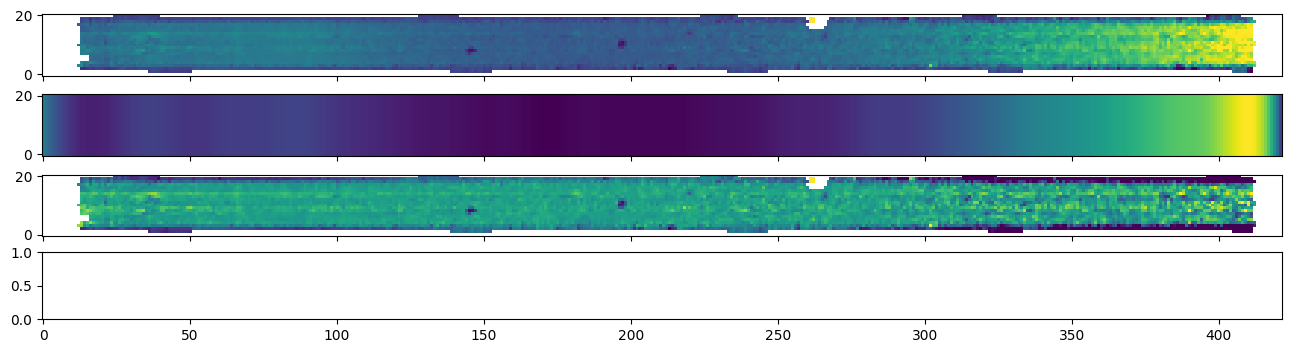

In [22]:
from BNBG.Pipeline.BetterBackgroundSubtractStep import getSourcePosition, modelBackgroundFromImage
from sklearn.decomposition import PCA

slit = s2ds[0].slits[30]

Y, X = np.indices(slit.data.shape)
_, _, dataLambda = slit.meta.wcs.transform("detector", "world", X, Y)

source = getSourcePosition(slit)

bspline = modelBackgroundFromImage(slit.data.copy(),
						slit.err.copy(),
						dataLambda,
						source=source,
						interpolationKnots=0.1)

fig,ax = plt.subplots(4,1, sharex=True, figsize=(16,4))
z1,z2 = ZScaleInterval().get_limits(slit.data)
ax[0].imshow(slit.data, origin='lower', interpolation='none',vmin=z1, vmax=z2)

img = bspline(dataLambda)
ax[1].imshow(img, origin='lower', interpolation='none')

res = slit.data - img
z1,z2 = ZScaleInterval().get_limits(res)
ax[2].imshow(res, origin='lower', interpolation='none',vmin=z1, vmax=z2)

# Step 2: Apply PCA on residuals
pca = PCA(n_components=5)  # Choose top 5 components
pca_residuals = pca.fit_transform(res.T).T

# Step 3: Reconstruct using top components
reconstructed_residuals = pca.inverse_transform(pca_residuals.T).T

ax[3].imshow(reconstructed_residuals, origin='lower', interpolation='none')
plt.show()

